In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()
import math
import pickle

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Escalado de features
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import scipy.stats as stats

# Crear datasets
from sklearn.datasets import make_regression

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [4]:
df_train_processed = pd.read_pickle('./data/df_train_processed.pkl')

open_file = open('./data/df_param_dict.pkl', "rb")
param_dict = pickle.load(open_file)
open_file.close()

df_test_processed = pd.read_pickle('./data/df_test_processed.pkl')

In [5]:
X = df_train_processed.drop(['label'], axis=1)
y = df_train_processed['label']             

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=df_train_processed['label'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.1, shuffle=True, stratify=y_train)

print("Train:", len(X_train))
print("Tests:", len(X_test))
print("Validation:", len(X_val))

Train: 297
Tests: 83
Validation: 33


In [6]:
def evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Model='logistic'):

    if Model == 'logistic':
        model = LogisticRegression(max_iter=1000)
    elif Model == 'random_forest':
        model = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
    elif Model == 'gradient_boosting':
        model = GradientBoostingClassifier()
    elif Model == 'svm':
        model = SVC(kernel='linear', probability=True)
    elif Model == 'knn':  
        model = KNeighborsClassifier(n_neighbors=9, metric="minkowski", p=2)
    elif Model == 'decision_tree_classifier':  
        model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
    else:
        raise ValueError("Model type not recognized")

    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    # Calculamos la matriz de confusión
    cm = confusion_matrix(y_test, y_pred_test)
    accuracy_val = accuracy_score(y_pred_val, y_val)
    precision_val = precision_score(y_pred_val, y_val)
    recall_val = recall_score(y_pred_val, y_val)
    f1_val = f1_score(y_pred_val, y_val)

    metrics_val_df = pd.DataFrame({
        'Modelo': [Model],
        'Accuracy': [accuracy_val],
        'Precision': [precision_val],
        'Recall': [recall_val],
        'F1': [f1_val],
        'cm': [cm]
    })

    # Calculamos la probabilidad del modelo
    prob_total = model.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

    # Realizamos la curva roc
    fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

    # Ploteamos la curva
    plt.plot(fpr_total, tpr_total, label=f"Modelo: {Model}")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel("Tasa de falsos positivos")
    plt.ylabel("Tasa de verdaderos positivos")

    # Calculamos el auc
    print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

    accuracy_test = accuracy_score(y_pred_test, y_test)

    return metrics_val_df

Modelo con todos los atributos AUC: 0.8050724637681159
Modelo con todos los atributos AUC: 0.9018115942028986
Modelo con todos los atributos AUC: 0.8492753623188406
Modelo con todos los atributos AUC: 0.8130434782608695
Modelo con todos los atributos AUC: 0.7844202898550724
Modelo con todos los atributos AUC: 0.7126811594202899
                     Modelo  Accuracy  Precision    Recall        F1  \
0                  logistic  0.696970   0.791667  0.791667  0.791667   
1             random_forest  0.696970   0.833333  0.769231  0.800000   
2         gradient_boosting  0.727273   0.875000  0.777778  0.823529   
3                       svm  0.757576   0.875000  0.807692  0.840000   
4                       knn  0.818182   0.916667  0.846154  0.880000   
5  decision_tree_classifier  0.727273   0.833333  0.800000  0.816327   

                    cm  
0   [[8, 15], [7, 53]]  
1   [[14, 9], [3, 57]]  
2   [[14, 9], [9, 51]]  
3   [[9, 14], [5, 55]]  
4  [[10, 13], [4, 56]]  
5  [[14, 9], [1

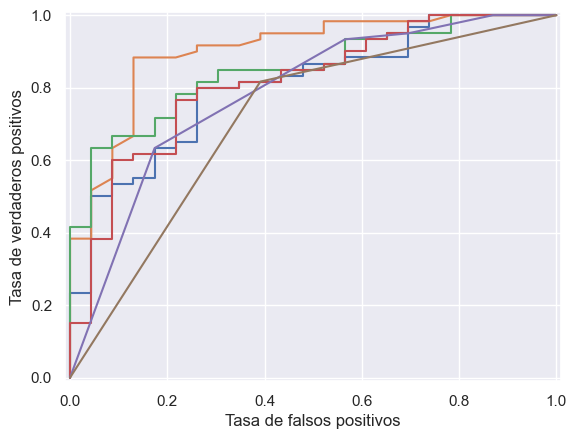

In [7]:
df_result = pd.DataFrame()

df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Model='logistic')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Model='random_forest')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Model='gradient_boosting')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Model='svm')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Model='knn')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Model='decision_tree_classifier')], ignore_index=True)

print(df_result)

In [53]:

svm_linear = SVC(kernel='rbf', probability=True)

grid = GridSearchCV(svm_linear,
                    {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100]},
                    refit=True,
                    cv=5,
                    scoring='accuracy')
